<a href="https://colab.research.google.com/github/mattjperez/hands-on-ml/blob/master/03_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification with MNIST

## Load MNIST dataset from sklearn's database

In [0]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

##Preview and get to know the data




In [0]:
mnist['DESCR']

"**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  \n**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  \n**Please cite**:  \n\nThe MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  \n\nIt is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 

In [0]:
X, y = mnist['data'], mnist['target']

In [0]:
X.shape  #70,000 images, 28x28 pixels (784 pixels total)

(70000, 784)

In [0]:
y.shape  # Single Label per observation (i.e., 8, 0, 3, etc)

(70000,)

In [0]:
!pip install matplotlib

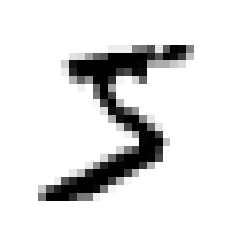

In [57]:
import matplotlib as mpl
import matplotlib.pyplot as plt

# Reshape the feature sets into their original 28x28 format
# "View" the image using a binary mapping of the reformatted observation

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [0]:
y[0]  # The label for the first observation is indeed 5

'5'

In [0]:
# As the label is a string, need to reformat to an integer
import numpy as np

y = y.astype(np.uint8)

In [0]:
# Now that you know how the data set works, split the training and test sets

X_train, X_test, y_train, y_test = X[:60_000], X[60000:], y[:60000], y[60000:]

## Training a Binary Classifier (True or False)

Start small, train a classifier to distinguish between what is 5 and what's not 5

In [0]:
y_train_5 = (y_train == 5)  #True for all 5s, False for all other digits
y_test_5 = (y_test == 5)

Stochastic Gradient Descent handles large datasets efficiently, so we'll start with that. 

Since it's stochastic, you can set a seed.

In [0]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [0]:
sgd_clf.predict([some_digit])

array([ True])

##Performance Measures

###Measuring Accuracy with Cross-Validation

#### Hand-Coded Cross-Validation

For those that may want to develop your own implementation of cross_val_score() for a tailored process.

In [0]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=2, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
  clone_clf = clone(sgd_clf)
  X_train_folds = X_train[train_index]
  y_train_folds = y_train[train_index]
  X_test_fold = X_train[test_index]
  y_test_fold = y_train_5[test_index]

  clone_clf.fit(X_train_folds, y_train_folds)
  y_pred = clone_clf.predict(X_test_fold)
  n_correct = sum(y_pred == y_test_fold)
  print(n_correct / len(y_pred))

0.09876666666666667
0.10136666666666666


#### Built-in Cross-Validation

In [0]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

Pay attention to the 95% accuracy in the above cross-validation. Always get suspicious with that kind of result on an initial pass. 

That was for checking if a digit is a 5. Let's see how it does at checking if things aren't 5's. 

In [0]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
  def fit(self, X, y=None):
    return self
  def predict(self, X):
    return np.zeros((len(X), 1), dtype=bool)

never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")


array([0.91125, 0.90855, 0.90915])

**RED FLAG** The classifier is accurate 90% of the time. Coincicentally /s, in our data set, 5's make up about 10% of all observations. If the classifier just says nothing is a 5, it'll always get 90% accuracy. 

Accuracy is generally not the preferred way to measure classifier performance, especially with a skewed dataset (in this case, 10% for one value, 90% for 
another)

### Confusion Matrices, Precision and Recall

A confusion matrix is a much better way to measure the performance of a classifier. It will show true positives, true negatives, false positives, and false negatives. 

Instead of right and wrong, it's more like 'how right?' or 'how wrong'.

**Note from Statquest** Using a confusion matrix is excellent to determine Type 1 and Type 2 Errors. What's more important for your use case? If it's detecting cancer, having some false positives is much more preferable to having false negatives. A false negative could prevent someone who needs medical attention from popping on the radar. 

In [0]:
# we need predictions to run through the confusion matrix

from sklearn.model_selection import cross_val_predict

# instead of returning evaluation scores, this returns predictions on each fold

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [0]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

What a perfect classifier's confusion matrix would look like (highly unlikely)

In [0]:
y_train_perfect_predictions = y_train_5

confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

**Precision** is the percent-accuracy of classifier.



```
Precision = True Positives / (True Positives + False Positives)
```
- Out of everything classified as Positive, how many were correctly classified
- When this classifier picks marbles from a bag that it thinks are green, how often is it correct?


**Recall** aka **Sensitivity** aka **True Positive Rate (TPR)** 



```
True Positives / (True Positives + False Negatives)
```

- Out of all the Actual Positives, how many were correctly classified?
- How good is this classifier at finding all of the green marbles in a bag?

In [0]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)


0.8370879772350012

In [0]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

When this classifier detects a 5, it **is right 83.7% of the time**.

This classifier only **detects 65.1% of the 5's** in the set. 

**F<sub>1</sub> Score** is the *harmonic mean* of precision and recall. 

Harmonic mean is a weighted mean, with more weight to low values.

This means the F<sub>1</sub> score will only be high if **both** precision and recall are high. 


```
F1 = 2 / ((1/precision) + (1/recall)) = 2 * ((precision * recall) / (precision+ recall))
```



In [0]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

**Note:** The F<sub>1</sub> metric favors similar scores (i.e., when precision is similar to sensitivity). This is not always desired, depending on the use case (like the cancer detection example).

**Note 2:** Precision and Sensitivity have a similar relationship to that of bias and variance, thus there's a similar trade-off. The Precision/Recall trade-off.

## Decision Threshold

For each instance/observation, a score is generated. If that score passes a certain threshold, it will be classified as A, otherwise it will be classified as B. 

Modifying this threshold will affect the Precision and Recall conversely. Lowering the threshold may allow you to classify more of Class A (Recall), but this will also increase the amount of B that is misclassified as A, lowering your Precision. 

You can't set the threshold directly, but you can access the decision scores it uses for its predictions. Instead of **predict()**, you can use **decision_function()** to see the score for each instance. You can adjust the threshold using these scores as a reference. 

In [0]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [0]:
threshold = 0  # everything will pass the threshold
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [0]:
threshold = 8000  # nothing will pass the threshold
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

### Optimal Threshold

First, you need predictions to work with. More specifically, you need the decision scores of these predictions. This can be done using a parameter in cross_val_predict().

In [0]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

Using these scores, you can iterate through different thresholds and find their corresponding precision-recall scores at diffent threshold values. 

In [0]:
# Compute precision-recall scores for all possible thresholds

from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)


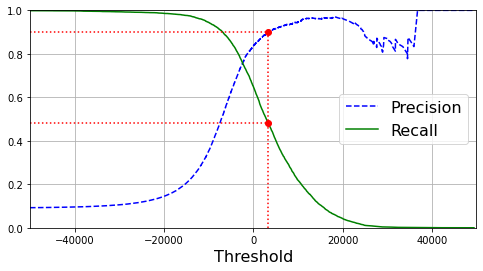

In [0]:
# Plot precision and recall as a function of threshold value

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1], "b--", label='Precision')
  plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
  plt.legend(loc="center right", fontsize=16) # Not shown in the book
  plt.xlabel("Threshold", fontsize=16)        # Not shown
  plt.grid(True)                              # Not shown
  plt.axis([-50000, 50000, 0, 1])             # Not shown

recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
plt.show()

The red dots show where 90% precision and its corresponding recall value. 
The upper red-dotted area shows the range you can play with to find your ideal trade-off.

**Note:** Precision can get bumpy because the score is relative to targets and non-targets above the threshold at a given time whereas recall can only go down as the threshold increases, appearing smooth.  

### Direct Precision-to-Recall Plot

Precision and Recall can be plotted against eachother and you can make a visual 
judgement on how to maximize the trade-off. 

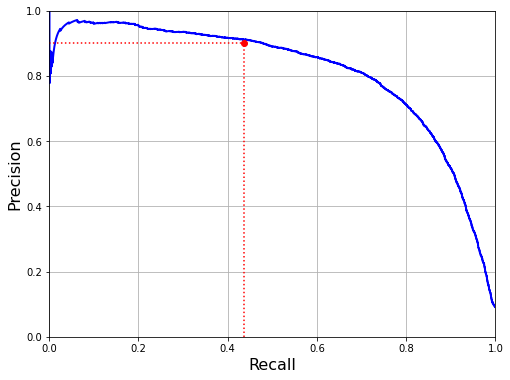

In [0]:
# Code wasn't shown in book

def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([0.4368, 0.4368], [0., 0.9], "r:")
plt.plot([0.0, 0.4368], [0.9, 0.9], "r:")
plt.plot([0.4368], [0.9], "ro")
plt.show()

You can use the desired precision to reference the first plot and find an approximate threshold. Alternatively, you can use numpy's argmax function to find the first threshold value that will fulfill the desired condition


```
precision >=0.90
```



In [0]:
threshold_90_precision = thresholds[np.argmax(precisions>=0.90)]
threshold_90_precision

3370.0194991439557

We can see what the actual precision and recall are at the specified threshold.

In [0]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [0]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

Therefore, with a threshold of 3370:
- When the classifier detects a 5, 90% of the time, it is correct.
- The classifier will detect ~48% of all the 5s.

The book says a high-precision classifier is not very useful if its recall is too low. What about for investments? Trying to catch every unicorn would be insane. With investing, not losing money is more important than making money. This seems like a possible approach for that. 

## ROC and AUC

The **Receiver Operating Characteristic** (ROC). 

The name comes from its roots in WWII, used to measure a radar's performance at detecting enemy aircraft. 

ROC curve plots True Positive Rate (Recall) against False Positive Rate

False Positive Rate = 1 - True Negative Rate (aka specificity)

The thresholds variable will store the thresholds that gives the corresponding FPR and TPR.


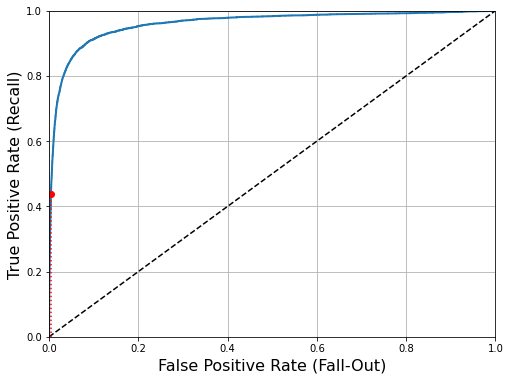

In [0]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0,1], [0,1], 'k--')  # Plots a diagonal dotted line across the screen
  plt.axis([0, 1, 0, 1])                                    # Not shown in the book
  plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
  plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
  plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") # Not shown
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  # Not shown
plt.plot([4.837e-3], [0.4368], "ro")               # Not shown
plt.show()

The higher the Recall, the more False Positives you'll get. 

**Note:** The dotted line is the ROC of a purely random classifier (50/50, like flipping a coin). The better the classifier, the more to the top left the curve will be. 

The **Area Under Curve** (AUC) is exactly as it sounds. 

It's the percent of that plot that falls under the curve as a percentage. A perfect classifier will have an AUC of 1.0 and a random classifier would be about 0.5 (area of graph under the dotted line).

In [0]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

**Note:** You should prefer the Precision-Recall Curve over ROC when:
- the number of Positives is rare (fraudulant charges vs real charges)
- you are concerned about False Positives more than False Negatives

Otherwise, use ROC/AUC.

This scenario was an example of the first bullet point. By looking at the PR Curve, you can see there's still a lot of room for improvement while the ROC/AUC says it's doing really well. 

### A Random Forest ROC/AUC vs an SGD's 

Generate predictions to be used for the confusion matrix, PR, and ROC.

Random Forests don't use decision_function(). Instead they use predict_proba().
This shows the probability an observation is one class or another.

**Note:** Scikit-Learn classifiers usually have one of these methods, but sometimes have both.

In [0]:
# Generate predictions using Random Forest Classifier

from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, 
                                    cv=3, method='predict_proba')

In [0]:
# Use the predictions to find the FPR and TPR at different thresholds

y_scores_forest = y_probas_forest[:, 1]  # All rows, column 1 (Probability is Positive)
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

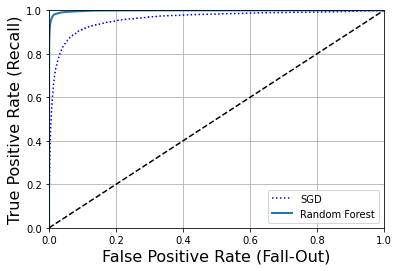

In [0]:
# Plot the ROC Curve of SGD and RandomForest on the same graph for comparison

plt.plot(fpr, tpr, "b:", label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')
plt.legend(loc='lower right')
plt.show()

**Note:** Call the main plot function last.

The graph shows the Random Forest performing much better than SGD. 
We can find the AUC for the actual difference.

In [0]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

ROC/AUC
- SGD: 96%
- RFC: 99.8%
- Delta: 3.8%

In [0]:
# Convert RFC's probabilities to 1s and 0s
y_scores_forest_int = np.round(y_scores_forest).astype(int)

precision_score(y_train_5, y_scores_forest_int)

0.9905083315756169

In [0]:
recall_score(y_train_5, y_scores_forest_int)

0.8662608374838591

Precision
- SGD: 83.7%
- RFC: 99.1%
- Delta: ~16%

Recall
- SGD: 65.1%
- RFC: 86.6%
- Delta: ~21%

## Multiclass Classification

Binary Classifiers distinguish between two classes. Multiclass Classifiers (aka multinomial classifiers) distinguish between multiple classes.

>Binary Classifiers:
- Logistic Regression
- Support Vector Machines

>Multiclass Classifiers:
- Stochastic Gradient Descent
- Random Forest
- Naive Bayes

Binary classifiers can be used for multiclass purposes, but it needs one classifier per label. The classifier with the highest decision score determines the final prediction. This is called one-versus-the-rest (OvR) or one-versus-all. 

**Note** Sounds like a Neural Network

Another strategy is one-versus-one (OvO), that has as many classifiers as there are pair combinations. 

```
C(10, 2) = 45 combinations = 45 classifiers
```
The main advantage is that each classifier only needs to train on a subset of the data. 

**Note:** SVM scales poorly depending on the size of the training set, so this approach is preferred. Most binary classifiers work better with OvR though.

**Note 2:** Scikit-learn can tell if you use a binary classifier for multiclass purposes. It'll automatically use OvR or OvO depending on classifier's defaults.
 

### Multiclass SVM (default= OvO)

In [0]:
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train, y_train)  # full y_train, not the set of just 5s
svm_clf.predict([some_digit])

array([5], dtype=uint8)

Under the hood, SVM created 45 binary classifiers which gave each observation an array of 10 decision scores, one for each possible label.

In [0]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [0]:
# Target classes stored in .classes_ ordered by value, 
# Luckily our labels match their indices

svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [0]:
# When using non-numerical numers, can verify the label of a specific index

svm_clf.classes_[5]  #index, returns label

5

In [0]:
# Prediction can also be seen using the argmax function

np.argmax(some_digit_scores)

5

### Multiclass SVM (OvR)

To force a binary classifier to use another approach, use one of the following classes:
- OneVsOneClassifier()
- OneVsRestClassifier()

**Warning** The next code block takes about 60min on Google colab

In [0]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [0]:
# Number of binary classifiers made

len(ovr_clf.estimators_)

10

### Multiclass Classifier

No need to run OvR or OvO because these classifiers can work directly with the full training data. The decision_function() method will return 1 instead of 10 or 45

In [0]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [0]:
# Decision scores assigned to each class

sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

The classifier is very confident about its prediction, only one other label having a positive score, and it's one-fifth that of the correct label. This means there is model feels there's a slight possibility the label is a 3 instead of a 5. Like doubt. 

In [0]:
# checking SGD's accuracy

cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

It does well at around 85%, but let's try preprocessing the inputs using a standard scaler. 

**Note:** This is a common preprocessing technique done to images before being used in a convolutional neural network.

**Note 2:** The reason this works better is because a zero-centered unit like a z-score is easier for the model to work with as opposed to a range of 0 to 255. 

Imagine if you had to repeatedly reference the mean and instead of an easy number like 0 you have to constantly compute it because it changes with every set, subset, or single observation. 

In [52]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.8983, 0.891 , 0.9018])

Scores much better. Always check what preprocessing techniques work well with your data's format and the chosen model. 

## Error Analysis

This next part is for after you've:
- explored the data
- try multiple models
- select candidate models
- and fine-tune the hyperparameters

This section is about analyzing the types of errors your model makes.

In [53]:
# Start with a confusion matrix

x_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5860,   63,    0,    0,    0,    0,    0,    0,    0,    0],
       [6675,   67,    0,    0,    0,    0,    0,    0,    0,    0],
       [5932,   26,    0,    0,    0,    0,    0,    0,    0,    0],
       [5913,  218,    0,    0,    0,    0,    0,    0,    0,    0],
       [5821,   21,    0,    0,    0,    0,    0,    0,    0,    0],
       [1891, 3530,    0,    0,    0,    0,    0,    0,    0,    0],
       [5796,  122,    0,    0,    0,    0,    0,    0,    0,    0],
       [6251,   14,    0,    0,    0,    0,    0,    0,    0,    0],
       [5741,  110,    0,    0,    0,    0,    0,    0,    0,    0],
       [5903,   46,    0,    0,    0,    0,    0,    0,    0,    0]])

When the numbers are confusing, you can use matplotlib's matshow() function for a nice graphical representation.

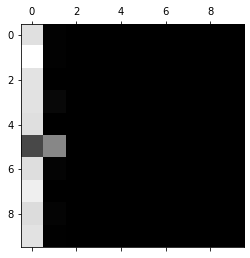

In [54]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In this grayscale image, 5 is slightly darker than the rest. This can mean:
1. There are fewer images of 5s in the dataset
2. or the classifier doesn't do well with 5s

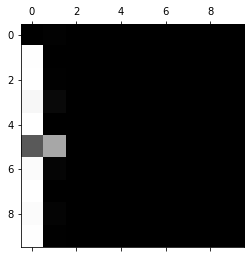

In [55]:
# divide matrix by number of observations per class for relative errors instead of absolute
# absolute errors make abundant classes look comparatively worse

row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

# fill diagonal with zeroes to focus on errors

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

Rows represent actual class while columns represent predicted class.

Bright columns (predicted label) mean more misclassifications of that label. The brighter the box, the less precision (more false positives)

A dark row (actual label) means higher sensitivity to that label. 

This model seems to have a high sensitivity to 8s but lower precision for 8s. 8s are usually classified correctly, but non-8s are often misclassified as 8s.

Ways you can **improve precision** on 8s:
- Use more training data that looks like 8s but aren't.
- Engineer new features to help the classifier (like counting loops)
- Preprocess the image to make loops stand out more (Scikit-Image, Pillow, OpenCV).

**Analyzing individual errors** are a great way to get an idea of what's going wrong, but can difficult and time-consuming. 

The 3s and 5s seem to be misclassified as eachother often. Let's take a look at the actual images.

In [2]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

NameError: ignored

The 5x5 blocks on the left are classified as 3s by the model.

The 5x5 blocks on the right are classified as 5s.

The linear classifier used (SGD) uses the weights of the pixels which it then sums up. Since 3s and 5s differ by only a few pixels, their sums are similar and easily confused for one another. 

The main difference between 3 and 5 is the joint that connects the top of the number to the bottom. If the joint is to the left of center it might classify a 5; a 3 if it's right of center. This means the **this classifier is sensitive to image shifting and rotation**. Try preprocessing the images to ensure centeredness and minimal rotation to help reduce errors. 

## Multilabel Classification

In [59]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

The np.c_ concats column-wise (adding the array/matrix to the right), np.r_ would concat row-wise (adding the array/matrix to the bottom). 

Like stacking matrices (np.r_) vs augmenting a matrix (np.c_)

**Note:** This method reminds me of OneHotEncoding

In [61]:
# Predicts if Large[0] and/or Odd[1]

knn_clf.predict([some_digit])

array([[False,  True]])

One approach to evaluating a multilabel classifier is calculating the F<sub>1</sub> score of each label, then compute the average. The next code computes the average F<sub>1</sub> score across all labels.

In [0]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average='macro')

This method assumes all labels are equally important, but that may not be the case if one label is more prominant overall than others. One method is to give each label a weight equal to its support (number of instances with that target label). To do that, just change 'macro' from the code above to 'weighted'. 

##Multioutput Classification

Multioutput-Multiclass Classification (or just Multioutput Classification). Each label can have multiple classes.

The example in the book reduces noise from an image (looks like static). The labels are:
1. label per pixel
2. intensity of the pixel (0-255)

In [0]:
# create training set by adding noise to MNIST images via randint

noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [0]:
# checking out the result on a test image (which is bad practice)

some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

In [0]:
# training the classifier to clean the image

knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)